# Load data into X, y arrays

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
# from pytorch_lightning.loggers.csv_logs import CSVLogger

In [12]:
# https://www.kaggle.com/tartakovsky/pytorch-lightning-lstm-timeseries-clean-code#TimeseriesDataset
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class PowerConsumptionDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading 
      and processing work in one place.
    '''
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        '''
        Data is resampled to hourly intervals.
        Both 'np.nan' and '?' are converted to 'np.nan'
        'Date' and 'Time' columns are merged into 'dt' index
        '''

        if stage == 'fit' and self.X_train is not None:
            return 
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:  
            return
        
        path = data_dir / 'Household_power_consumption.csv'

        df = pd.read_csv(
            path, 
            parse_dates={'dt' : ['datetime']}, 
            infer_datetime_format=True, 
            low_memory=False, 
            na_values=['nan','?'], 
            index_col='dt'
        )

        df_resample = df.resample('h').mean()

        X = df_resample.dropna().copy()
        y = X['Global_active_power'].shift(-1).ffill()
        self.columns = X.columns


        X_cv, X_test, y_cv, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
    
        X_train, X_val, y_train, y_val = train_test_split(
            X_cv, y_cv, test_size=0.25, shuffle=False
        )

        preprocessing = StandardScaler()
        preprocessing.fit(X_train)

        if stage == 'fit' or stage is None:
            self.X_train = preprocessing.transform(X_train)
            self.y_train = y_train.values.reshape((-1, 1))
            self.X_val = preprocessing.transform(X_val)
            self.y_val = y_val.values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = preprocessing.transform(X_test)
            self.y_test = y_test.values.reshape((-1, 1))
        

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader


In [68]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        h_s, c_s = self.lstm(x)
        y_pred = self.linear(h_s[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss


In [69]:
p = dict(
    seq_len = 24,
    batch_size = 70, 
    criterion = nn.MSELoss(),
    max_epochs = 10,
    n_features = 8,
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

In [70]:
from pytorch_lightning.loggers.csv_logs import CSVLogger

csv_logger = CSVLogger(data_dir, name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    gpus=1,
    progress_bar_refresh_rate=2,
)

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

dm = PowerConsumptionDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cats/datastore/data/minconda3/envs/pl/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/cats/datastore/data/minconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory /cats/datastore/data/lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 44.0 K
2 | linear    | Linear  | 101   
--------------------------------------
44.1 K    Trainable para

Epoch 0:   3%|▎         | 12/396 [00:00<00:04, 93.91it/s, loss=3.45, v_num=0]

/cats/datastore/data/minconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/cats/datastore/data/minconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 99/99 [00:00<00:00, 548.17it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.2353, device='cuda:0')}
--------------------------------------------------------------------------------


/cats/datastore/data/minconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


[{'test_loss': 0.23532330989837646}]

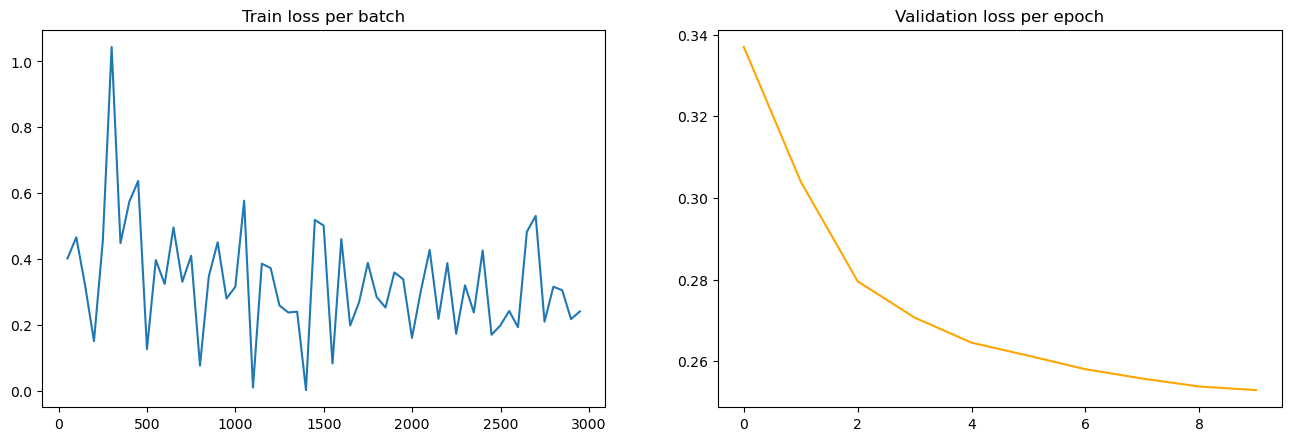

MSE:
Train loss: 0.241
Val loss:   0.253
Test loss:  0.235


In [71]:
metrics = pd.read_csv(data_dir / 'lstm/0/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

In [73]:
from argparse import ArgumentParser

import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.optimizer import Optimizer


class LinearRegression(pl.LightningModule):
    """
    Linear regression model implementing - with optional L1/L2 regularization
    $$min_{W} ||(Wx + b) - y ||_2^2 $$
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int = 1,
        bias: bool = True,
        learning_rate: float = 1e-4,
        optimizer: Optimizer = Adam,
        l1_strength: float = 0.0,
        l2_strength: float = 0.0,
        **kwargs
    ):
        """
        Args:
            input_dim: number of dimensions of the input (1+)
            output_dim: number of dimensions of the output (default=1)
            bias: If false, will not use $+b$
            learning_rate: learning_rate for the optimizer
            optimizer: the optimizer to use (default='Adam')
            l1_strength: L1 regularization strength (default=None)
            l2_strength: L2 regularization strength (default=None)
        """
        super().__init__()
        self.save_hyperparameters()
        self.optimizer = optimizer

        self.linear = nn.Linear(in_features=self.hparams.input_dim, out_features=self.hparams.output_dim, bias=bias)

    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch

        # flatten any input
        x = x.view(x.size(0), -1)

        y_hat = self(x)

        loss = F.mse_loss(y_hat, y, reduction='sum')

        # L1 regularizer
        if self.hparams.l1_strength > 0:
            l1_reg = sum(param.abs().sum() for param in self.parameters())
            loss += self.hparams.l1_strength * l1_reg

        # L2 regularizer
        if self.hparams.l2_strength > 0:
            l2_reg = sum(param.pow(2).sum() for param in self.parameters())
            loss += self.hparams.l2_strength * l2_reg

        loss /= x.size(0)

        tensorboard_logs = {'train_mse_loss': loss}
        progress_bar_metrics = tensorboard_logs
        return {'loss': loss, 'log': tensorboard_logs, 'progress_bar': progress_bar_metrics}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        return {'val_loss': F.mse_loss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_mse_loss': val_loss}
        progress_bar_metrics = tensorboard_logs
        return {'val_loss': val_loss, 'log': tensorboard_logs, 'progress_bar': progress_bar_metrics}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.mse_loss(y_hat, y)}

    def test_epoch_end(self, outputs):
        test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_mse_loss': test_loss}
        progress_bar_metrics = tensorboard_logs
        return {'test_loss': test_loss, 'log': tensorboard_logs, 'progress_bar': progress_bar_metrics}

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.hparams.learning_rate)

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        parser.add_argument('--input_dim', type=int, default=None)
        parser.add_argument('--output_dim', type=int, default=1)
        parser.add_argument('--bias', default='store_true')
        parser.add_argument('--batch_size', type=int, default=16)
        return parser


def cli_main():
    from pl_bolts.datamodules.sklearn_datamodule import SklearnDataModule

    pl.seed_everything(1234)

    # create dataset
    from sklearn.datasets import load_boston

    # args
    parser = ArgumentParser()
    parser = LinearRegression.add_model_specific_args(parser)
    parser = pl.Trainer.add_argparse_args(parser)
    args = parser.parse_args()

    # model
    model = LinearRegression(input_dim=13, l1_strength=1, l2_strength=1)
    # model = LinearRegression(**vars(args))

    # data
    X, y = load_boston(return_X_y=True)  # these are numpy arrays
    loaders = SklearnDataModule(X, y, batch_size=args.batch_size)

    # train
    trainer = pl.Trainer.from_argparse_args(args)
    trainer.fit(model, train_dataloader=loaders.train_dataloader(), val_dataloaders=loaders.val_dataloader())


cli_main()

ModuleNotFoundError: No module named 'pl_bolts'